# Physics Informed FNO for Nonlinear Shallow Water Equations

This example demonstrates physics informing of a
data-driven model using numerical derivatives (PINO).

## Problem overview

To examine the properties of PINOs with 3 coupled nonlinear equations, we
examined the ability of the networks to reproduce the nonlinear shallow water
equations. These equations are applicable in several physical scenarios
including tsunami modeling.  We assumed that the total fluid column height
$\eta(x,y,t)$ was composed of a mean height plus some perturbation,
but the initial velocity fields $u(x,y,t)$ and $v(x,y,t)$ were initially
zero. These equations are given by

$$\begin{align}
\frac{\partial(\eta)}{\partial t}+\frac{\partial(\eta u)}{\partial x}+
\frac{\partial(\eta v)}{\partial y}&=0,  \\
\frac{\partial(\eta u)}{\partial t}+
\frac{\partial}{\partial x}\left(\eta u^{2}+\frac{1}{2} g
\eta^{2}\right)+
\frac{\partial(\eta u v)}{\partial y}&=\nu\left(u_{xx} + u_{yy}\right), \\
\frac{\partial(\eta v)}{\partial t}+\frac{\partial(\eta u v)}{\partial x}+
\frac{\partial}{\partial y}\left(\eta v^{2}+\frac{1}{2} g
\eta^{2}\right)&=\nu\left(v_{xx} + v_{yy}\right),
\end{align}$$

$$\begin{align}
\textrm{with} \quad \eta(x,y,0) = \eta_{0}(x,y),\ u(x,y,0)=0,\
v(x,y,0)=0,\ \quad
x,y \in[0,1), \ t \in[0,1],
\end{align}$$

where the gravitational coefficient $g=1$ and the viscosity coefficient
$\nu=0.002$ to prevent the formation of shocks. Below we plot how each of these
fields evolves in space and time according to the PINO predictions and the
simulated data.  We observe that the error in each of these cases is relatively small.

<!-- {: .center} -->
![Nonlinear Shallow Water Equations 2D predictions](../../../docs/img/SWE_0.png)

We will demonstrate the use of data loss and physics constraints,
specifically the equation residual loss, to create accurate predictions.
[PhysicsNeMo Sym](https://github.com/NVIDIA/physicsnemo-sym)
has utilities tailored for physics-informed machine learning. It also presents
abstracted APIs that allow users to think and model the problem from the lens of
equations, constraints, etc. In this example, we will only leverage the physics-informed
utilities to see how we can add physics to an existing data-driven model with ease while
still maintaining the flexibility to define our own training loop and other details.
For a more abstracted definition of these type of problems, where the training loop
definition and other things is taken care of implicitly, you may refer
[PhysicsNeMo Sym](https://github.com/NVIDIA/physicsnemo-sym)


## Dataset

The training and validation datasets for this example can be found on the
[PINO Applications Github page](https://github.com/shawnrosofsky/PINO_Applications).

To demonstrate the usefulness of the Physics loss, we will deliberately choose a smaller
dataset size of 45 samples. In such regiemes, the effect of physics loss is more
evident, as it regularizes the model in the absence of large data.

In [1]:
!python download_data.py

Creating data...
SWE NL dataset is detected, you need to delete previous dataset to download new one
Done!


## Prerequisites

Install the requirements using:

```bash
pip install -r requirements.txt
pip install nvidia-physicsnemo.sym --no-build-isolation
```

in your virutal environment

## Model overview and architecture

In this example, we will use a Fourier Neural Operator (FNO). and then compute the
derivatives in a PINO style, using Numerical differentiation with Fourier derivatives.
With this example, we intend to demonstrate how to implement multiple
equations into the loss function.

In this example, we will also use the `PDE` class from PhysicsNeMo-Sym to symbolically define
the PDEs. This is very convinient and most natural way to define these PDEs and allows
us to print the equations to check for correctness. This also abstracts out the
complexity of converting the equation into a pytorch representation. PhysicsNeMo Sym also
provides several complex, well-tested PDEs like 3D Navier-Stokes, Linear elasticity,
Electromagnetics, etc. pre-defined which can be used directly in physics-informing
applications. We will also give you the option to choose between the
derivative functions from PhysicsNeMo-Sym or from the original paper.  


# Training

### Import Dataloader, Loggeres, Checkpoint utilites, loss functions and others

```python
import hydra
from omegaconf import DictConfig
import torch
import numpy as np
import os

import matplotlib.pyplot as plt
from hydra.utils import to_absolute_path
from torch.utils.data import DataLoader
import torch.nn.functional as F

from physicsnemo.models.fno import FNO
from physicsnemo.launch.logging import LaunchLogger
from physicsnemo.launch.utils.checkpoint import save_checkpoint

from train_utils.datasets import DataLoader2D_swe
from swe_nl_pde import SWE_NL
from train_utils.losses import (
    swe_loss,
    ic_loss,
    pino_loss_swe_nonlin,
    physicsnemo_fourier,
)
from train_utils.plot import plot_predictions, generate_movie
```

### PhysicsNeMo uses hydra for passing the config file. Use inbuilt Loggers for logging

```python
@hydra.main(version_base="1.3", config_path=".", config_name="config_pino.yaml")
def main(cfg: DictConfig):
    # CUDA support
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    LaunchLogger.initialize()
```

### Define 2D Nonlinear Shallow Waters PDEs using PhysicsNeMo sym utilities
```python
swe_nl = SWE_NL(g=cfg.data.g, nu=cfg.data.nu)
swe_nl_node = swe_nl.make_nodes()
```

### Load in dataset and make dataloader
```python
    data = torch.load(
        to_absolute_path("datasets/swe_nl_dataset.pt"),
        map_location=torch.device("cpu"),
        weights_only=True,
    )
    dataset = DataLoader2D_swe(
        data, cfg.data.nx, cfg.data.nt, cfg.data.sub, cfg.data.sub_t
    )

    train_loader = dataset.make_loader(
        cfg.data.n_train, cfg.batchsize, start=0, train=True
    )
    test_loader = dataset.make_loader(
        cfg.data.n_test, cfg.batchsize, start=cfg.data.n_train, train=False
    )
```

### Define FNO model architecture
```python
    model = FNO(
        in_channels=cfg.model.fno.in_channels,
        out_channels=cfg.model.fno.out_channels,
        decoder_layers=cfg.model.fno.decoder_layers,
        decoder_layer_size=cfg.model.fno.decoder_layer_size,
        dimension=cfg.model.fno.dimension,
        latent_channels=cfg.model.fno.latent_channels,
        num_fno_layers=cfg.model.fno.num_fno_layers,
        num_fno_modes=cfg.model.fno.num_fno_modes,
        padding=cfg.model.fno.padding,
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), betas=(0.9, 0.999), lr=cfg.start_lr
    )

    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=cfg.milestones, gamma=cfg.gamma
    )

    S, T = dataset.S, dataset.T
    batch_size = cfg.batchsize
    padding = cfg.model.fno.padding
    nfields = cfg.model.fno.out_channels
```

### Training loop: Loss computation
```python
    for epoch in range(cfg.max_epochs):
        # wrap epoch in launch logger for console logs
        with LaunchLogger(
            "train",
            epoch=epoch,
            num_mini_batch=len(train_loader),
            epoch_alert_freq=10,
        ) as log:
            for x, y in train_loader:
                # Pad input to be put into model
                x, y = x.to(device), y.to(device)
                x_in = F.pad(x, (0, 0, 0, padding), "constant", 0)
                x_in = x_in.permute(0, 4, 3, 1, 2)
                # compute forward pass and unpad output
                out = (
                    model(x_in)
                    .permute(0, 3, 4, 2, 1)
                    .reshape(batch_size, S, S, T + padding, nfields)
                )
                out = out[..., :-padding, :]
                s0 = x[..., 0, -1]

                # Compute PDE loss using 'physicsnemo' functions or method from 'original' paper
                if cfg.loss.derivative == "original":
                    loss_pde = pino_loss_swe_nonlin(
                        out,
                        g=cfg.data.g,
                        nu=cfg.data.nu,
                        h_weight=cfg.loss.h_loss,
                        u_weight=cfg.loss.u_loss,
                        v_weight=cfg.loss.v_loss,
                    )
                elif cfg.loss.derivative == "physicsnemo":
                    loss_pde = physicsnemo_fourier(
                        out,
                        swe_nl_node,
                        h_weight=cfg.loss.h_loss,
                        u_weight=cfg.loss.u_loss,
                        v_weight=cfg.loss.v_loss,
                    )

                # Compute data loss
                loss_l2 = swe_loss(out, y, H=cfg.data.H)

                # Compute initial condition loss
                loss_ic = ic_loss(out, s0)

                # Compute total loss
                loss = (
                    cfg.loss.ic_loss * loss_ic
                    + cfg.loss.xy_loss * loss_l2
                    + cfg.loss.f_loss * loss_pde
                )

                # Backward pass and optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                log.log_minibatch(
                    {
                        "train loss": loss,
                        "train loss_ic": loss_ic.detach(),
                        "train loss_l2": loss_l2.detach(),
                        "train loss_pde": loss_pde.detach(),
                    }
                )
            # Learning rate update
            scheduler.step()
            log.log_epoch({"Learning Rate": optimizer.param_groups[0]["lr"]})
```

## Run Training

In [2]:
!python train_swe_nl_pino.py

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:91: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _EPOCH_DATETIME_NAIVE = datetime.datetime.utcfromtimestamp(0)
[2025-08-20 19:40:59,366][train][INFO] - Epoch 0 Metrics: Learning Rate =  1.000e-03, train loss =  1.050e+02, train loss_ic =  2.662e-01, train loss_l2 =  1.034e+01, train loss_pde =  2.508e-01
[2025-08-20 19:40:59,366][train][INFO] - Epoch Execution Time:  1.253e+01s, Time/Iter:  2.784e+02ms
[2025-08-20 19:40:59,366][checkpoint][WARNING] - `DistributedManager` not initialized already. Initializing now, but this might lead to unexpected errors
/usr/local/lib/python3.12/dist-packages/physicsnemo/distributed/manager.py:403: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this

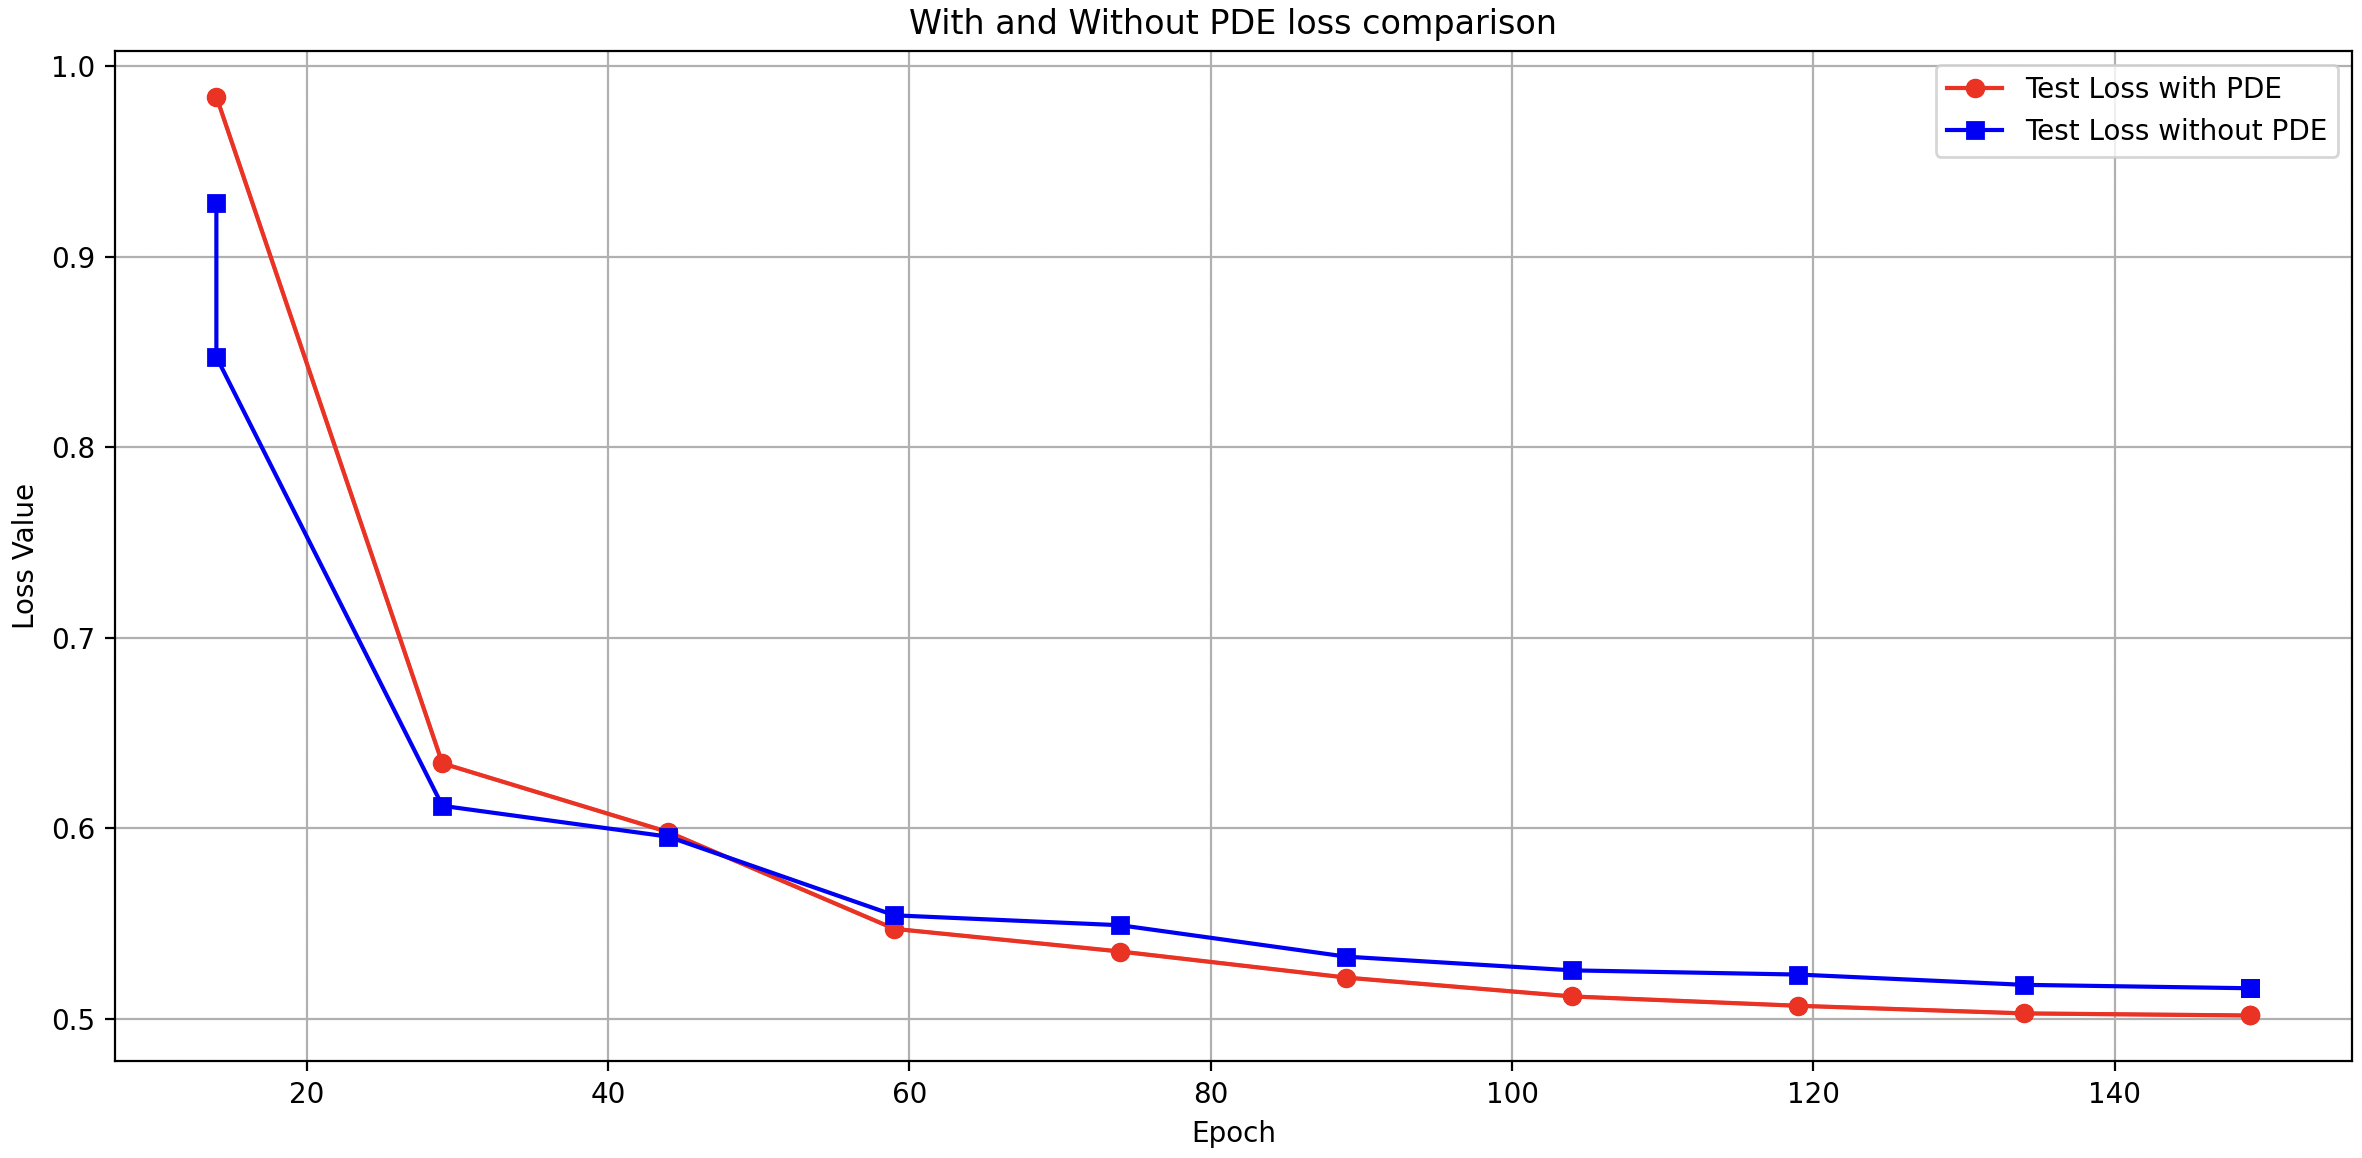